In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

Using TensorFlow backend.


In [2]:
#loading data
DDataFile = './D_VLOS_scaled_mean_mean_alpha6_fft_abs_Frobenius_sphericalWave_B32_U20000.mat'
DData = sio.loadmat(DDataFile)

LocationDataFile = './randLocationU20000VIP.mat'
locationData = sio.loadmat(LocationDataFile)


In [182]:
#preprocessing the data
D_data = np.transpose(DData['D'])
location_data = np.transpose(locationData['location'])
location_data = location_data[:,:2]

#print(D_data.shape)
total, l = D_data.shape
total, d = location_data.shape

train_length = int(np.floor(total * 0.8))

impulses_train = D_data[:train_length, :]
location_train = location_data[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = D_data[train_length:, :]
location_test = location_data[train_length:,:]

20000 16000 (16000, 1024) (16000, 2)


The **best** result for now is use **Three 1024** hidden layers and activation is relu, the actual error distance is 25.8, lr = 0.0001
-  ~~the first layer is 256~~
- ~~decrease lr = 0.00001~~
- *bitch size changes to  32, the avgrage actual error distance is 26.86*
- ~~try to sort the data according to the location x and use the half of data to calculate~~
- change the size of validation to 0.1 --> **The best result** 25.45

- add one more layer 1024, which means there are four 1024 layers

In [194]:
#Build the model
model = keras.Sequential()

#keras.layers.normalization.BatchNormalization()
#model.add(Dropout(0.25)) # best 0.2
model.add(Dense(1024, activation = 'relu'))  #tanh(343,1794)   relu (680,1600)   #the hidden layer number 

#keras.layers.normalization.BatchNormalization()
#model.add(Dropout(0.25)) # best 0.2
model.add(Dense(1024, activation = 'relu'))  #tanh(343,1794)   relu (680,1600)   #the hidden layer number 

#keras.layers.normalization.BatchNormalization()
#model.add(Dropout(0.25)) # best 0.2
model.add(Dense(1024, activation = 'relu'))  #tanh(343,1794)   relu (680,1600)   #the hidden layer number 

#model.add(Dropout(0.25)) # best 0.2
model.add(Dense(1024, activation = 'relu'))  #tanh(343,1794)   relu (680,1600)   #the hidden layer number 

model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [195]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr=0.0001) #'Adam'  lr=0.001  #  RMSprop(overfiiting) sgd(overfitting)  Adadelta(overfitting)   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )

#best set: categorical_crossentropy  and sgd, but the loss and acc do not change....

In [196]:
#Train the model, iterating
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.1)
history = model.fit(impulses_train, location_train,
                    batch_size = 50, # 10,20
                    epochs = 300,
                    verbose = 2,
                    validation_split = 0.1 #0.2
                    #validation_data=(impulses_test, location_test)
                   )


Train on 14400 samples, validate on 1600 samples
Epoch 1/300
 - 18s - loss: 48711.8799 - val_loss: 8017.5075
Epoch 2/300
 - 19s - loss: 5397.0245 - val_loss: 3711.9839
Epoch 3/300
 - 20s - loss: 2863.2156 - val_loss: 2396.5863
Epoch 4/300
 - 21s - loss: 2133.3411 - val_loss: 2008.4616
Epoch 5/300
 - 21s - loss: 1850.3453 - val_loss: 1825.0374
Epoch 6/300
 - 19s - loss: 1733.5357 - val_loss: 1790.3981
Epoch 7/300
 - 17s - loss: 1650.1143 - val_loss: 1705.6586
Epoch 8/300
 - 17s - loss: 1593.4522 - val_loss: 1614.8157
Epoch 9/300
 - 20s - loss: 1534.1222 - val_loss: 1617.4062
Epoch 10/300
 - 21s - loss: 1483.8879 - val_loss: 1521.3356
Epoch 11/300
 - 20s - loss: 1437.0396 - val_loss: 1527.5612
Epoch 12/300
 - 19s - loss: 1380.1291 - val_loss: 1438.6417
Epoch 13/300
 - 19s - loss: 1320.0767 - val_loss: 1416.6687
Epoch 14/300
 - 19s - loss: 1271.2865 - val_loss: 1338.0671
Epoch 15/300
 - 19s - loss: 1233.5022 - val_loss: 1321.6902
Epoch 16/300
 - 19s - loss: 1172.6507 - val_loss: 1288.0272

KeyboardInterrupt: 

In [186]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

(4000, 2)
(4000, 2)


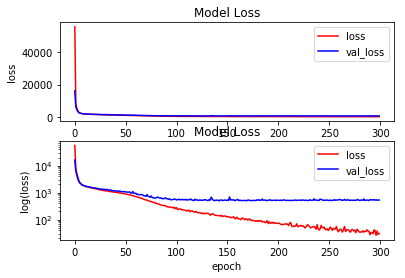

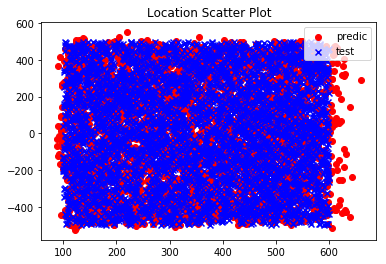

In [187]:
#plot the loss data
import math
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(212)
plt.semilogy(history.history['loss'],'r',label = 'loss')
plt.semilogy(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Location Scatter Plot')
ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
plt.legend()
plt.show()

In [188]:
#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

4000/4000 [==============================] - 1s 211us/step
Test loss & mean_absolute_error:  553.0393498535157


error distance is  25.457426821465706
max error distance is  158.5440315220744
min error distance is  0.08138472688965946


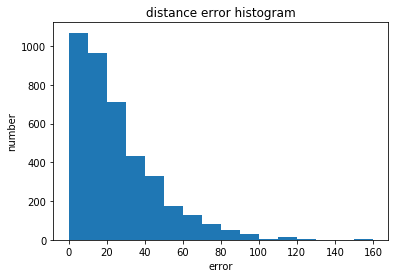

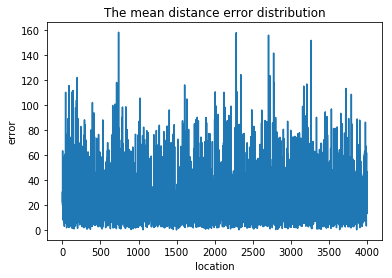

(4000, 1)

In [193]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_abs = np.abs(err)
err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(err_dis, bins =  range(0,170,10)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.figure(2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

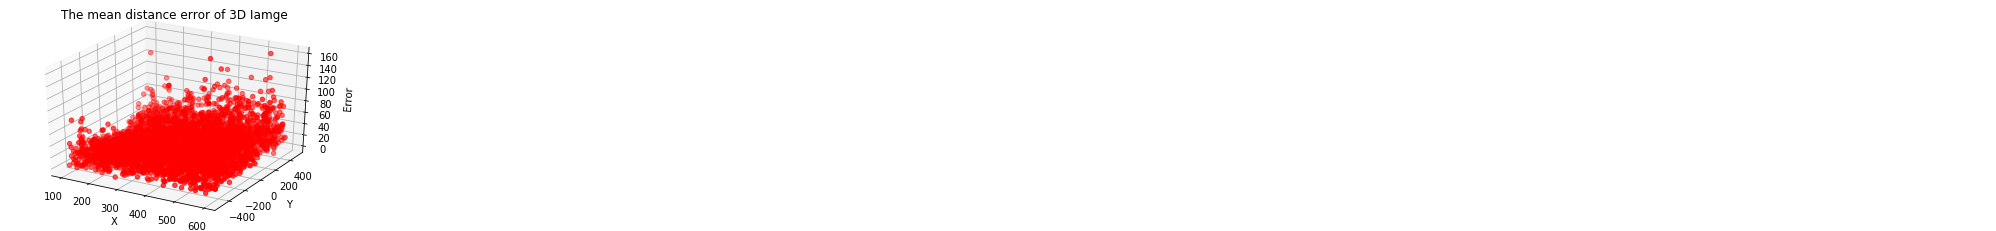

In [191]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

Text(0.5, 1.0, "The mean distance error of 'heat map'")

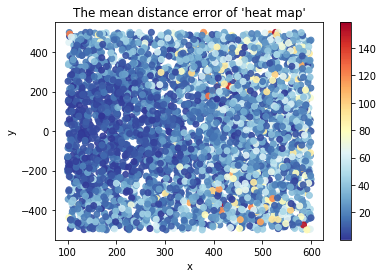

In [190]:
#draw the "heatmap" of error
fig = plt.figure()
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")